# imports

In [2]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# problem setup

\begin{align*}
    J[u] &= \int_{0}^{t_f} \frac{1}{2}u(t)^2 \, dt - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)
\end{align*}

\begin{align*}
\mathbf{x}(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix} &
\mathbf{x}'(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}' =  \begin{bmatrix} y'(t) \\ u(t) - 9.8 \end{bmatrix} &
\mathbf{x}(0) &= \begin{bmatrix} y_0 \\ 0 \end{bmatrix} &
\mathbf{x}(t_f) &= \begin{bmatrix} \text{free} \\ 0 \end{bmatrix} &
\end{align*}

\begin{equation}
H = \mathbf{p} \cdot \mathbf{f} - L 
 = p_0 y' + p_1 (u - 9.8) - \frac{1}{2} u^2
\end{equation}

\begin{align*}
p_0' &= -\frac{\partial H}{\partial y} = 0 \\
p_1' &= -\frac{\partial H}{\partial y'} = -p_0
\end{align*}

\begin{align*}
p_0(t_f) &= -\frac{\partial \phi}{\partial y(t_f)} = \left(\frac{-1}{\sigma^2}\right) \left( 2y(t_f) - (L+U) \right) \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right) \\
p_1(t_f) &= \text{free}
\end{align*}

\begin{align*}
\frac{ \partial H}{\partial u} = 0 = p_1 - u \implies \tilde{u} = p_1
\end{align*}

# solve the simple $\frac{1}{2}u(t)^2$ version

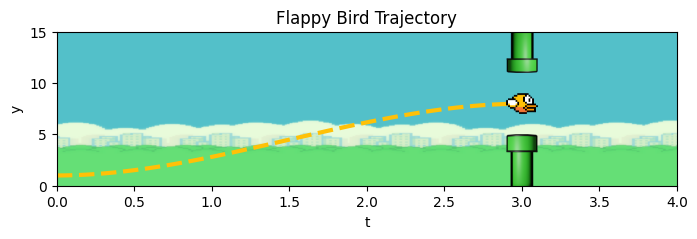

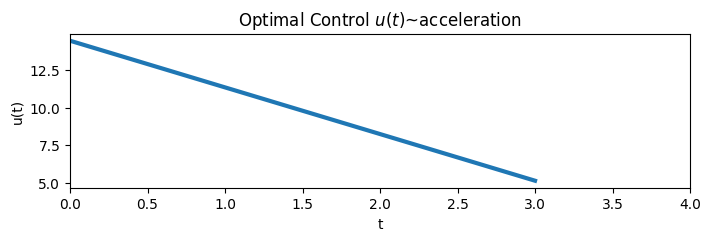

In [3]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 3
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 9.8
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    u = p1
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.ones(t_steps)
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0)

# extract the values from the solution
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
u = p1

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, 4)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = ylims[0], L
img = mpimg.imread('images/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = 2.9, 3.1
ymin, ymax = 7, 9
bird = mpimg.imread('images/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$~acceleration")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# similar-to-sine version

\begin{align*}
    J[u] &= \int_{0}^{t_f} W \left(u(t) - \max\{0, \sin(\alpha t)\} \right)^2 \, dt - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)
\end{align*}

\begin{align*}
\mathbf{x}(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix} &
\mathbf{x}'(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}' =  \begin{bmatrix} y'(t) \\ u(t) - 9.8 \end{bmatrix} &
\mathbf{x}(0) &= \begin{bmatrix} y_0 \\ 0 \end{bmatrix} &
\mathbf{x}(t_f) &= \begin{bmatrix} \text{free} \\ 0 \end{bmatrix} &
\end{align*}

\begin{equation}
H = \mathbf{p} \cdot \mathbf{f} - L 
 = p_0 y' + p_1 (u - 9.8) - \left(u(t) - \max\{0, \sin(\alpha t)\} \right)^2
\end{equation}

\begin{align*}
p_0' &= -\frac{\partial H}{\partial y} = 0 \\
p_1' &= -\frac{\partial H}{\partial y'} = -p_0
\end{align*}

\begin{align*}
p_0(t_f) &= -\frac{\partial \phi}{\partial y(t_f)} = \left(\frac{-1}{\sigma^2}\right) \left( 2y(t_f) - (L+U) \right) \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right) \\
p_1(t_f) &= \text{free}
\end{align*}

\begin{align*}
\frac{ \partial H}{\partial u} = 0 = p_1 + 2(u(t) - \sin(\alpha t)) \implies \tilde{u} = W \left(\sin(\alpha t) -\frac{p_1}{2}\right)
\end{align*}

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.48e-02       2.71e-07          100             6       
       2          1.23e-02       9.46e-09          106             6       
       3          6.40e-03       9.79e-10          112             5       
       4          2.81e-03       1.05e-11          117             5       
       5          1.32e-03       6.24e-13          122             3       
       6          9.72e-04       2.12e-14          125             0       
Solved in 6 iterations, number of nodes 125. 
Maximum relative residual: 9.72e-04 
Maximum boundary residual: 2.12e-14


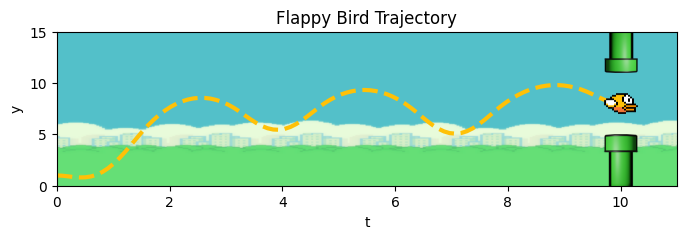

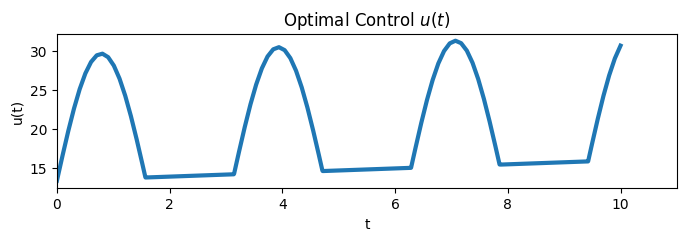

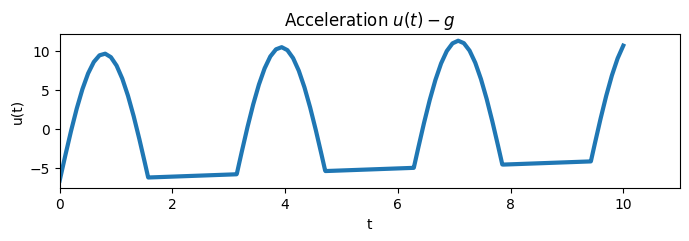

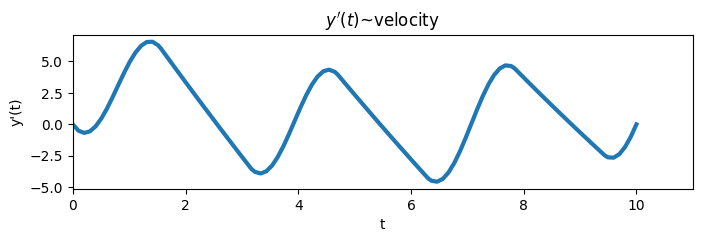

In [10]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 10
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 20
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

TAPS = 2
TAP_FORCE = 0.8*g

def u_f(p1, t):
    sin_part = np.sin(TAPS*t)
    sin_part = np.clip(sin_part, 0, np.abs(sin_part))
    res = -p1/2 + TAP_FORCE*sin_part
    res = np.clip(res, 0, np.abs(res))
    return res

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    
    u = u_f(p1, t)
    
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
    
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.sin(TAPS*np.linspace(t0, tf, t_steps))
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0, verbose=2)

# extract the values from the solution
t = sol.x
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
#u = fsolve(lambda u: p1*np.cos(u) - np.cos(u), np.linspace(0, 2*np.pi, len(y)))
u = u_f(p1, t)

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,2)
xlims = (0, tf+1)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/extra/flappy_background.png')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
PIPE_WIDTH = 0.3
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/extra/pipe_cropped_upper.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = ylims[0], L
img = mpimg.imread('images/extra/pipe_cropped_lower.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = L+2, U-2
bird = mpimg.imread('images/extra/bird_cropped.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the u(t)
plt.title("Acceleration $u(t)-g$")
plt.plot(t, u - g, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# plot the velocity
plt.title("$y'(t)$~velocity")
plt.plot(t, yp, linewidth=3)
plt.xlabel("t")
plt.ylabel("y'(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

# multiple pipes

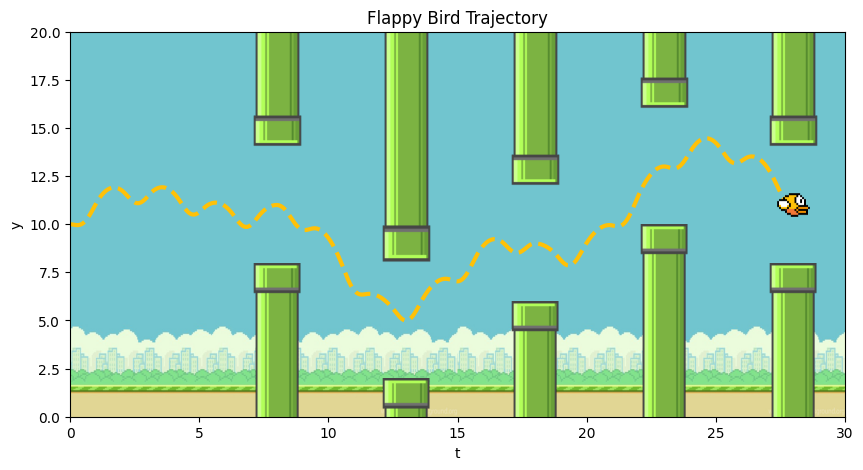

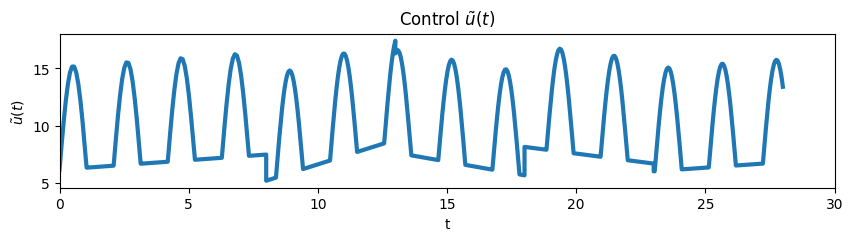

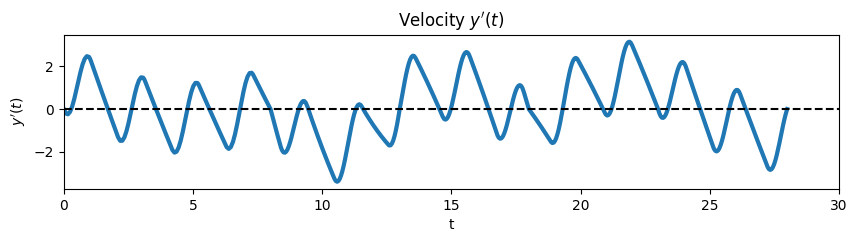

In [11]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

def get_sol(t0, tf, pipe_l, pipe_u, start_y, g=20, alpha=2, TAP_FORCE=0.8, sigma2=0.1**2, sine_weight=10, verbose=0):

    # determine how long to run the BVP solver
    t_steps = 100
    t = np.linspace(t0, tf, t_steps)

    # define the endpoint function and its derivative
    def phi(y_tf):
        return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
    def phi_d(y_tf):
        return (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

    # define the control relation to the co-state (comes from
    # the Lagrangian [u - sin(alpha t)]^2)
    def control(p1, t):
        sin_part = np.sin(alpha*t)
        sin_part = np.clip(sin_part, 0, np.abs(sin_part))
        res = -p1/2 + TAP_FORCE*sin_part
        res = np.clip(res, 0, np.abs(res))
        return res*sine_weight

    # setup the ode and boundary conditions for this problem
    def ode(t, y_var):
        y, yp, p0, p1 = y_var
        
        u = control(p1, t)
        
        zeros = np.zeros_like(y)
        ones = np.ones_like(y)
        return np.array([
            yp,         # y' = y'
            u - ones*g, # y'' = u - g
            zeros,      # p0' = -DH/Dy = 0
            -p0         # p1' = -DH/Dy' = -p0
        ])
    def bc(ya, yb):
        y_tf = yb[0]
        return np.array([
            ya[0] - start_y,         # y(0) = Sy
            ya[1] - 0,          # y'(0) = 0
            yb[1] - 0,          # y'(tf) = 0
            yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
        ])

    # setup an intial guess for the solution
    y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the solution with the ode, bc, and initial guess
    sol = solve_bvp(ode, bc, t, y0, verbose=verbose)

    # extract the values from the solution
    t = sol.x
    y = sol.y[0]
    yp = sol.y[1]
    p0 = sol.y[2]
    p1 = sol.y[3]

    # compute the optimal control
    u = control(p1, t)
    
    return {'t':t, 'y':y, 'yp':yp, 'p0':p0, 'p1':p1, 'u':u, 'accel':u - g}

############################################################
#                     PLOT THE RESULTS                     #
############################################################

Y_PLOT_LIMS = (0, 20)
PIPE_GAP = 6
g = 9.8
alpha = 3
TAP_FORCE = 0.9
sine_weight = 10

start_y = 10
pipe_ts = (np.arange(5)*5 + 8).tolist()
pipe_ls = [8, 2, 6, 10, 8]
pipe_us = [p + PIPE_GAP for p in pipe_ls]
times = [0] + pipe_ts

PIPE_WIDTH = (times[-1] - times[0]) / 30

curr_y = start_y
ts, ys, us, accels, velocities = [], [], [], [], []
for t0, tf, pipe_l, pipe_u in zip(times[:-1], times[1:], pipe_ls, pipe_us):
    
    sol = get_sol(t0, tf, pipe_l, pipe_u, curr_y, g=g, alpha=alpha, TAP_FORCE=TAP_FORCE, sine_weight=sine_weight)
    
    ts += sol['t'].tolist()
    ys += sol['y'].tolist()
    us += sol['u'].tolist()
    accels += sol['accel'].tolist()
    velocities += sol['yp'].tolist()
    
    curr_y = ys[-1]
    
PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(10,5)
xlims = (times[0], times[-1]+2)
ylims = Y_PLOT_LIMS
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(ts, ys, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/used/background.jpg')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the lower pipes
for pipe_t, pipe_l in zip(pipe_ts, pipe_ls):
    # load the image
    img = mpimg.imread('images/used/pipe_lower_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = ylims[0], pipe_l
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[:img_h, :, :]
    # add the iamge to the plot
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the upper pipes
for pipe_t, pipe_u in zip(pipe_ts, pipe_us):
    # load the image
    img = mpimg.imread('images/used/pipe_upper_long.png')
    # find the x and y limits for the pipe
    xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
    ymin, ymax = pipe_u, ylims[1]
    # truncate the image to only show the right amount of pipe
    ratio = (ymax - ymin) / 10
    h, w, c = img.shape
    img_h = int(h * ratio)
    img = img[-img_h:, :, :]
    # add the iamge to the plot
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    
# plot the bird
BIRD_SIZE = PIPE_WIDTH / 1.5
xmin, xmax = ts[-1]-BIRD_SIZE, ts[-1]+BIRD_SIZE
ymin, ymax = ys[-1]-BIRD_SIZE, ys[-1]+BIRD_SIZE
img = mpimg.imread('images/used/bird.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

plt.show()

plt.title(r"Control $\tilde{u}(t)$")
plt.gcf().set_size_inches(10,2)
xlims = (times[0], times[-1]+2)
plt.xlim(*xlims)
plt.xlabel("t")
plt.ylabel(r"$\tilde{u}(t)$")
plt.plot(ts, us, linewidth=3)
plt.show()

plt.title(r"Velocity $y'(t)$")
plt.gcf().set_size_inches(10,2)
xlims = (times[0], times[-1]+2)
plt.xlim(*xlims)
plt.xlabel("t")
plt.ylabel(r"$y'(t)$")
plt.plot(ts, velocities, linewidth=3)
plt.axhline(0, color='black', linestyle='--')
plt.show()



# endpoint reward

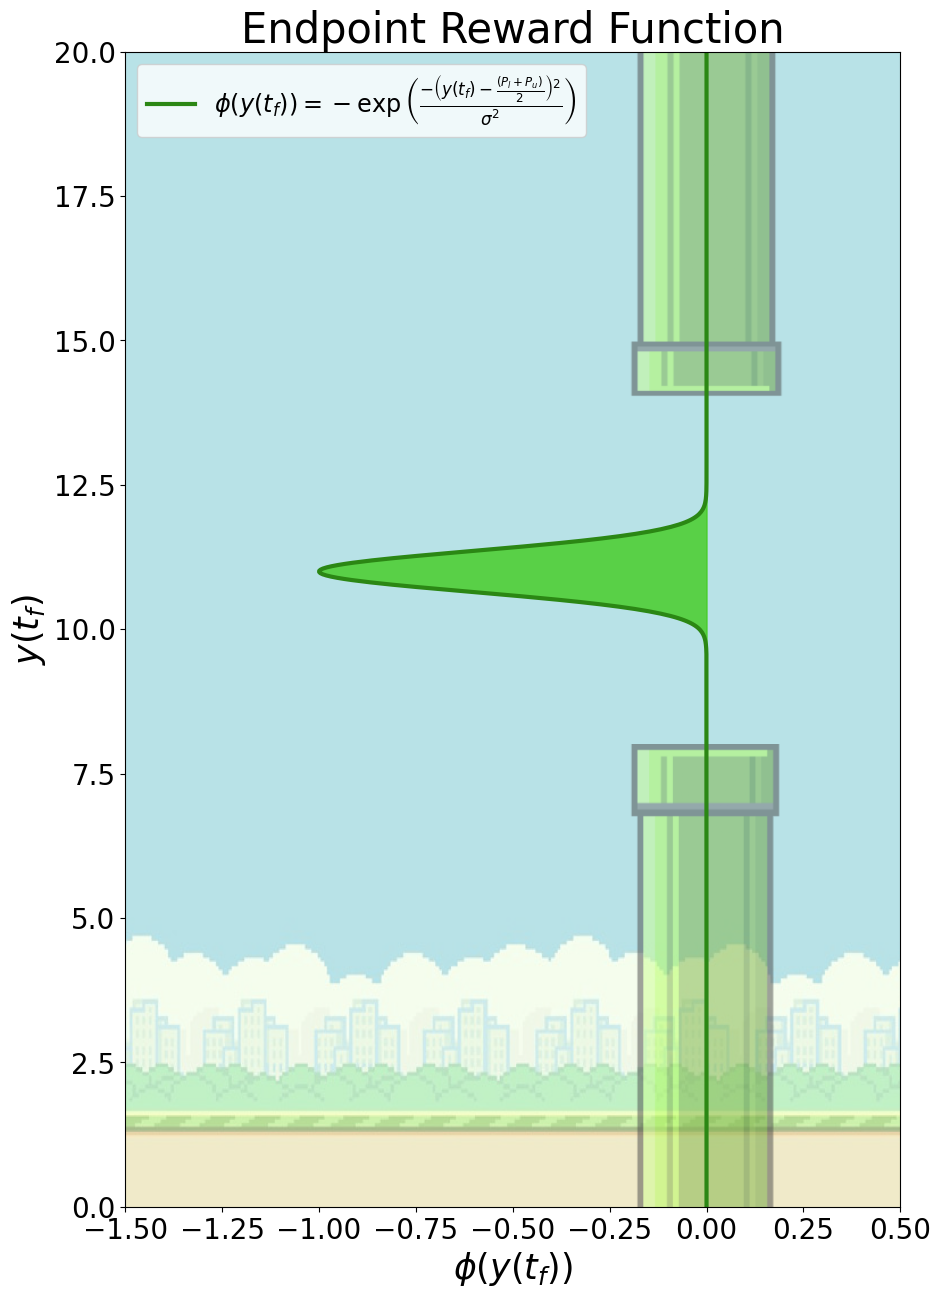

In [36]:
pipe_l = 8
pipe_u = 14
sigma2 = 0.5**2
def phi(y_tf):
    return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
ylims = (0, 20)
xlims = (-1.5, 0.5)
domain = np.linspace(ylims[0], ylims[-1], 1000)
xs = np.ones(1000)

bg_alpha = 0.5
pipe_alpha = 0.5

plt.xlim(*xlims)
plt.ylim(*ylims)
REWARD_COLOR = "#2b8714"
REWARD_COLOR_FILL = "#41cc1f"
equation_latex = r"$\phi (y(t_f)) = - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)$"
plt.plot(phi(domain), domain, REWARD_COLOR, linewidth=3, label=equation_latex)
plt.fill_betweenx(domain, phi(domain), x2=0, color=REWARD_COLOR_FILL, alpha=0.8)

# plot the background
background = mpimg.imread('images/used/background.jpg')
h, w, c = background.shape
background = background[:, :int(w // 3), :]
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=bg_alpha)

# plot the lower pipe
width = 0.2
xmin, xmax = 0-width, 0+width
ymin, ymax = ylims[0], pipe_l
img = mpimg.imread('images/used/pipe_lower_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

# plot the upper pipe
xmin, xmax = 0-width, 0+width
ymin, ymax = pipe_u, ylims[1]
img = mpimg.imread('images/used/pipe_upper_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

plt.gcf().set_size_inches(10, 15)
plt.title("Endpoint Reward Function", fontsize=30)
plt.xlabel(r"$\phi(y(t_f))$", fontsize=25)
plt.ylabel(r"$y(t_f)$", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize='xx-large')

plt.show()